[@lmaedler](https://www.uni-bremen.de/mvt/team/prof-dr-ing-habil-lutz-maedler) Jan. 3rd 2021
[@scendres](s.endres@iwt.uni-bremen.de) Oct. 29 2021

# Particle Coagulation ii

In this notebook we will study the parameter space of the coagulation model more extensively. To begin with we install some notebook widgets that will aid in the visualisation process.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
#from scipy.sparse import csr_matrix  # TODO, use a sparse matrix
#%matplotlib widget
import ipywidgets as widgets

import matplotlib.pyplot as plt
import numpy as np

try: 
    import ipympl
except ImportError:
    import sys
    !{sys.executable} -m pip install ipympl
try:
    from ipywidgets import *
except ImportError:
    import sys
    !{sys.executable} -m pip install ipwidgets

# Wrappers

Next we wrap all the routines from the previous notebook, so that we may call them more easily. First we wrap the discretisation of $ \frac{\partial n(v_p,t)}{\partial t} $ which will simplify the code for the time integration later.

In [2]:
# Wrap the numerical routine for serial dndt discretization

def dndt(n, beta_n, beta_diag, sum1_powers, sum2_powers, vp_num):
    """
    Returns the instantaneous dn/dt value at the current time step
    
    Variables:
        n : current particle number vector state
    Parameters:
        beta_n, beta_diag, sum1_powers, sum1_powers, vp_num : precomputed numerical parameters
    """
    # Start main simulation routine:
    np.zeros((vp_num))
    Sum1 = np.zeros((vp_num))
    Sum2 = np.zeros((vp_num))
    Sum3 = np.zeros((vp_num))
    dndt = np.zeros((vp_num))
    nn = n.copy()
    for i in range(1, vp_num, 1):
        sum1 = np.zeros((vp_num))
        sum2 = np.zeros((vp_num))
        sum3 = np.zeros((vp_num))
        for j in range(0, i - 1, 1):
            sum1[i] = sum1[i] + (2**(j-i+1) * beta_n[i-1,j] * nn[j])
        for j in range(0, i - 0, 1):    
            sum2[i] = sum2[i] + (2**(j-i) * beta_n[i,j] * nn[j])
        for j in range(i, vp_num - 1, 1): 
            sum3[i]= sum3[i] + (beta_n[i,j] * nn[j])
        dndt[i] = ( \
         nn[i-1] * sum1[i] + \
         1/2 * beta_n[i-1,i-1] * nn[i-1]**2 - \
         nn[i] * sum2[i] - \
         nn[i] * sum3[i]     
                     )


    #dndt[1:] = n[:-1] * Sum1[:-1]  + 1/2 * beta_diag[1:]* n[:-1]**2  - n[1:] * (Sum2[1:] + Sum3[1:])

    return dndt

Next we wrap the entire system that we want to simulate. It is important that you add all the different process parameters and initial conditions that you want to investigate in this function:

In [3]:
# Main system
def system(# Numerical parameters:
           t_total = 2e-0,                           # [s], change from 2e-4 to 2e-0 or any 
                                                     # other number   
           nt = 1000,                                # number of iteration steps 
           start_bin = 4,                 # this is an easy way to select a starting size
           # Physical parameters
           dp_min = 0.5e-9,                          # [m]
           dp_max = 1000e-9,                         # [m]
           T = 293,                                  # [K]
           rho_p = 1.0e3,                            # [kg / m^3]
           k_B = 1.380649e-23,                       # [J / K = N m / K = kg m^2 / s^2 / K]
           n_0_start_bin = 1e17                      # [#/m^3]
          ):
    """
    Simulates the whole system for the given numerical and physical parameters
    """
    # Initialization
    dt = t_total / nt                        # [s], small time step during the interation
    vp_min = np.pi/6 * (dp_min)**3           # [m^3]
    vp_max = np.pi/6 * (dp_max)**3           # [m^3])
    vp_num = int(np.log(vp_max / vp_min) // np.log(2) + 2)
    vp = np.zeros((vp_num))
    for i in range(vp_num): 
        vp[i] = vp_min * 2**i 

    n = np.zeros((vp_num))
        #dp_end = np.zeros((vp_num))
    dp_start = (6/np.pi * vp[start_bin])**(1/3)
    dp_end = (6/np.pi * vp)**(1/3)
    
    # Compute the vectorized kernel function:
    beta_pre = (3/(np.pi*4))**(1/6) * (6 * k_B * T / rho_p)**(1/2)
    # [kg m^2 / s^2 / K * K * m^3 / kg = m^5 /s^2]**(1/2) = [m^5/2 / s]
    beta_n = np.zeros((vp_num, vp_num)) # [m^5/2 / s * 1/m^3/2 * m2 = m^3/s]
    for i in range(vp_num): 
        for j in range(vp_num): 
            beta_n[i,j] = beta_pre * (1/vp[i] + 1/vp[j])**(1/2) * \
                          (vp[i]**(1/3) + vp[j]**(1/3))**2
            
    
    #
    # Initial conditions
    n_0 = np.zeros((vp_num))
    n_0[start_bin] = n_0_start_bin         # [#/m^3]
    n = n_0.copy()                # copy the initial condition to our interation array
    
    # Test one time step
    #ICs:
    n_0 = np.zeros((vp_num))
    n_0[start_bin] = n_0_start_bin# [#/m^3]
    n = n_0.copy()                # copy the initial condition to our interation array 

    # The beta diagonal is constant over the summation
    beta_diag = np.zeros_like(n_0)
    for i in range(1, vp_num, 1):
        beta_diag[i] = beta_n[i-1,i-1]
    beta_diag  # Equavalent to beta_diag = np.diag(beta_n)
    sum1_powers = np.zeros([vp_num, vp_num])
    #sum1_powers = csr_matrix([vp_num, vp_num])
    sum2_powers = np.zeros([vp_num, vp_num])
    for i in range(1, vp_num, 1):
        for j in range(0, i - 1, 1):
            sum1_powers[i, j] = 2**(j-i+1)
        for j in range(0, i - 0, 1): 
            sum2_powers[i, j] = 2**(j-i)
 
    
    nn = np.empty_like(n)
    for t in range(nt - 1):
        n = n + dndt(n, beta_n, beta_diag, sum1_powers, sum2_powers, vp_num) * dt
        
    return n, n_0, vp, vp_num, dp_end, start_bin, t_total

Next we wrap all the validations into a single function:

In [4]:
# First wrap the validations in a single function.
def validate(vp, n, n_0, t_total):
    print("Ratio of total particle volumes:", round(np.sum(vp * n) / np.sum(n_0 * vp) ,3) * 100,"%") 
    print("Ratio of total particle numbers:", round(np.sum(n)/np.sum(n_0),5) * 100,"%") 
    print("Estimated factor of diameter increase:", \
    round((1 + np.sum(n_0) * 1/2 * 1e-15 * t_total)**(1/3), 2))
    maximum_index = np.argmax(n)
    maximum_index_start = np.argmax(n_0)
    print("Computed factor of diameter increase:", \
          round((vp[maximum_index]/vp[maximum_index_start])**(1/3), 2))

Finally, we wrap the plotting routine 

In [5]:
# Now wrap the plotting function
def plot_distr(vp, vp_num, dp_end, n_0, start_bin):
    dp_start = np.zeros((vp_num))
    dp_end = np.zeros((vp_num))
    dp_start = (6/np.pi * vp[start_bin])**(1/3)
    dp_end = (6/np.pi * vp)**(1/3)
    fig, ax1 = plt.subplots()
    color1 = "tab:blue"
    ax1.semilogx(dp_end, n_0 / np.sum(n_0), drawstyle="steps-mid", \
                 label="before coagulation", color = color1) 
    ax1.set_ylabel("particle number in #/m^3", color = color1)
    ax1.tick_params(axis="y", labelcolor = color1)
    title_string = "normalized particle size distribution" + "\n" + \
        "total time = " + \
        str(np.format_float_scientific(t_total, precision=0)) + " s,  " + \
        "total particle number = " + \
        str(round(np.sum(n)/np.sum(n_0),5) * 100) + " %"
    ax1.set_title(title_string)
    ax1.set_xlabel("particle diameter in m")

    color2 = "tab:red"
    ax2 = ax1.twinx() 
    ax2.semilogx(dp_end, n / np.sum(n), drawstyle="steps-mid", \
                 label="after coagulation", color = color2) 
    ax2.set_ylabel("particle number in #/m^3", color = color2)
    ax2.tick_params(axis="y", labelcolor = color2)

    # ask matplotlib for the plotted objects and their labels
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)

    plt.tight_layout()
    plt.show()
    return ax1, ax2

Now we test the default starting conditions and see if we can replicate the results:

<IPython.core.display.Javascript object>


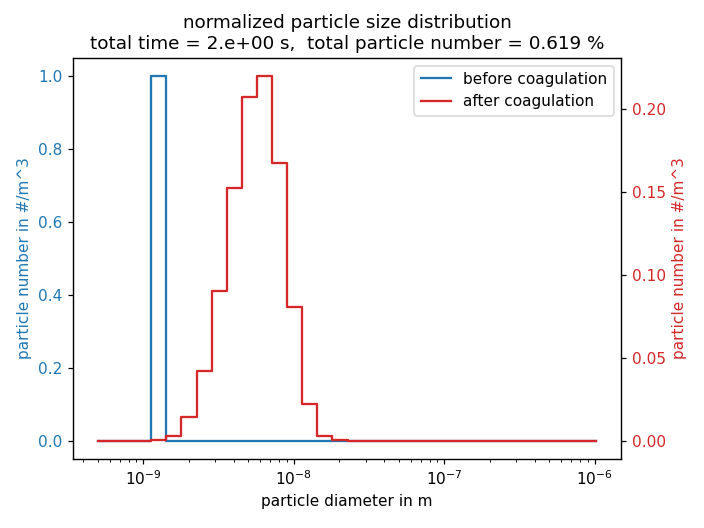

Ratio of total particle volumes: 100.0 %
Ratio of total particle numbers: 0.619 %
Estimated factor of diameter increase: 4.66
Computed factor of diameter increase: 5.04


((<AxesSubplot:title={'center':'normalized particle size distribution\ntotal time = 2.e+00 s,  total particle number = 0.619 %'}, xlabel='particle diameter in m', ylabel='particle number in #/m^3'>,
  <AxesSubplot:ylabel='particle number in #/m^3'>),
 None)

In [6]:
%matplotlib notebook
# Now test the default system
n, n_0, vp, vp_num, dp_end, start_bin, t_total = system()
# Plot the results and the validations
plot_distr(vp, vp_num, dp_end, n_0, start_bin), validate(vp, n, n_0, t_total)

Results should be:
Ratio of total particle volumes: 100.0 %
Ratio of total particle numbers: 0.619 %
Estimated factor of diameter increase: 4.66
Computed factor of diameter increase: 5.04

# Investigation
### Next we investigate the parameter space

<IPython.core.display.Javascript object>


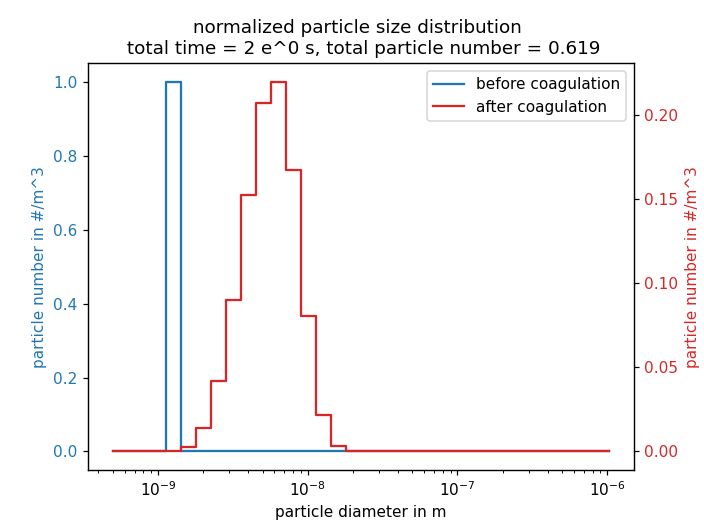

interactive(children=(IntSlider(value=2, description='t_total', max=9), IntSlider(value=0, description='t_tota…

In [7]:
#%matplotlib widget
%matplotlib notebook
#%matplotlib inline
def interactive_sim(t_total, start_bin,# dp_min, dp_max, 
                    rho_p, T, n_0):
    #
    # Now simulate the default system
    n, n_0, vp, vp_num, dp_end, start_bin, t_total = system(t_total=t_total, start_bin=start_bin, 
                                                   #dp_min=dp_min, dp_max=dp_max, 
                                                   rho_p=rho_p, 
                                                   T=T, n_0_start_bin=n_0)
    # Plot the results and the validations
    #plot_distr(vp, vp_num, dp_end, n_0, start_bin)
    validate(vp, n, n_0, t_total)
    return n, n_0, vp, vp_num, dp_end, start_bin
    

## Set up initial plot:

dp_start = np.zeros((vp_num))
dp_end = np.zeros((vp_num))
dp_start = (6/np.pi * vp[start_bin])**(1/3)
dp_end = (6/np.pi * vp)**(1/3)
fig, ax1 = plt.subplots()
color1 = "tab:blue"
line1, = ax1.semilogx(dp_end, n_0 / np.sum(n_0), drawstyle="steps-mid", \
             label="before coagulation", color = color1) 
ax1.set_ylabel("particle number in #/m^3", color = color1)
ax1.tick_params(axis="y", labelcolor = color1)
title_string = "normalized particle size distribution" + "\n" + \
    "total time = " + \
    str(np.format_float_scientific(t_total, precision=0)) + " s,  " + \
    "total particle number = " + \
    str(round(np.sum(n)/np.sum(n_0),5) * 100) + " %"
ax1.set_title(title_string)
ax1.set_xlabel("particle diameter in m")

color2 = "tab:red"
ax2 = ax1.twinx() 
line2, = ax2.semilogx(dp_end, n / np.sum(n), drawstyle="steps-mid", \
             label="after coagulation", color = color2) 
ax2.set_ylabel("particle number in #/m^3", color = color2)
ax2.tick_params(axis="y", labelcolor = color2)

# ask matplotlib for the plotted objects and their labels
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

#plt.tight_layout()
#plt.show()

           #dp_min = 0.5e-9,                          # [m]
           #dp_max = 1000e-9,                         # [m]

@widgets.interact(t_total=(0, 9, 1), t_total_order=(-2, 6, 1), start_bin=(2, 25, 1), 
                  #dp_min = (0.1e-9, 100e-9, 0.1e-9), dp_max = (1e-9, 1e6, 10e-9),
                  rho_p = (1, 10000, 100),
                  T=(253, 633, 10), n_0= (1e15, 1e18, 10))

def update(t_total = 2e-0, t_total_order=0, start_bin=4, 
          # dp_min = 0.5e-9, dp_max = 1000e-9, 
           rho_p = 1.0e3, T=293, n_0=1e17):
    """Remove old lines from plot and plot new one"""
    #t_total = np.log(log_t_total) \ #slider.valtext.set_text(t_total)
    t_total = t_total * 10**t_total_order
    
    n, n_0, vp, vp_num, dp_end, start_bin, t_total = system(t_total=t_total, start_bin=start_bin, 
                                                   #dp_min=dp_min, dp_max=dp_max, 
                                                   rho_p=rho_p, 
                                                   T=T, n_0_start_bin=n_0)
    #ax1, ax2 = plot_distr(vp, vp_num, dp_end, n_0, start_bin)
    validate(vp, n, n_0, t_total)

    # y-axis
    line1.set_ydata(n_0 / np.sum(n_0))
    line2.set_ydata(n / np.sum(n))
    # x-axis 
    dp_start = np.zeros((vp_num))
    dp_end = np.zeros((vp_num))
    dp_start = (6/np.pi * vp[start_bin])**(1/3)
    dp_end = (6/np.pi * vp)**(1/3)
    line1.set_xdata(dp_end)
    line2.set_xdata(dp_end)
        # Reset title
    title_string = f"normalized particle size distribution \n total time = {t_total} e^{t_total_order} s, total particle number = {str(round(np.sum(n)/np.sum(n_0),5) * 100)}" 
    ax1.set_title(title_string)

    fig.canvas.draw_idle()



## References

Singh, M., Kaur, G., De Beer, T., Nopens, I. "Solution of bivariate aggregation population balance equation: a comparative study", Reaction Kinetics, Mechanisms and Catalysis, 123 (2) 385-401 (2018). 

Nopens, I., Beheydt, D., Vanrolleghem, P.A. "Comparison and pitfalls of different discretised solution methods for population balance models: a simulation study", Computers & Chemical Engineering, 29 (2) 367-377 (2005). 

Lister, J., Smit, D., Hounslow, M. "Adjustable discretized population balance for growth and aggregation", AIChE Journal, 41 (3) 591-603 (1995). 

Hounslow, M., Ryall, R., Marshall, V. "A discretized population balance for nucleation, growth, and aggregation", AIChE journal, 34 (11) 1821-1832 (1988). 

Friedlander, S.K. "Smoke, Dust and Haze, Fundamentals of Aerosol Dynamics" 2nd ed., Oxford University Press, ISBN 0-19-512999-7 (2000)